In [127]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

data = pd.read_csv('food_demand.csv')
data.head()
data.tail()



,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders
456543,1271326,145,61,1543,484.09,484.09,0,0,68
456544,1062036,145,61,2304,482.09,482.09,0,0,42
456545,1110849,145,61,2664,237.68,321.07,0,0,501
456546,1147725,145,61,2569,243.50,313.34,0,0,729
456547,1361984,145,61,2490,292.03,290.03,0,0,162


In [128]:
data.dtypes

id                         int64
week                       int64
center_id                  int64
meal_id                    int64
checkout_price           float64
base_price               float64
emailer_for_promotion      int64
homepage_featured          int64
num_orders                 int64
dtype: object

indexing time to get timeseries

In [129]:
data.set_index('week',inplace=True)

In [130]:
weekly_order = data.groupby('week')['num_orders'].sum()
weekly_order

week
1       792261
2       787084
3       695262
4       743529
5      1198675
        ...   
141     776240
142     739661
143     759926
144     801197
145     671926
Name: num_orders, Length: 145, dtype: int64

In [131]:
weekly_order.isnull().sum()

np.int64(0)

Plot time series to get an overall idea of that series

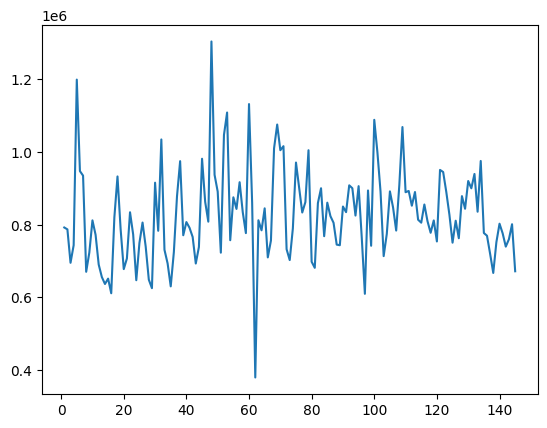

In [132]:
plt.plot(weekly_order)

To find trend and seasonality - decompose : Plot ACF to find periods

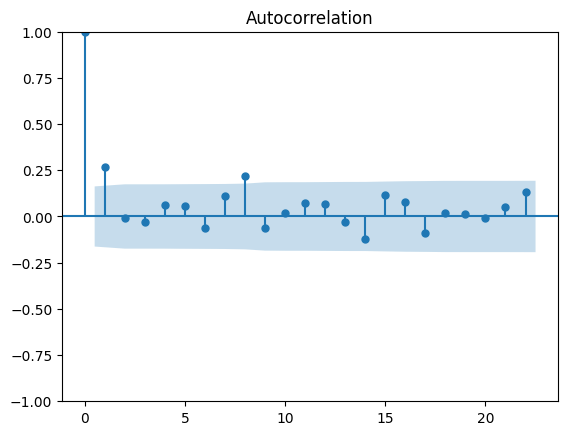

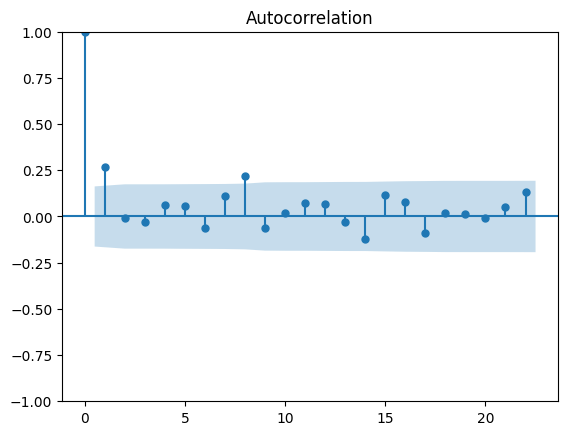

In [133]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(weekly_order)

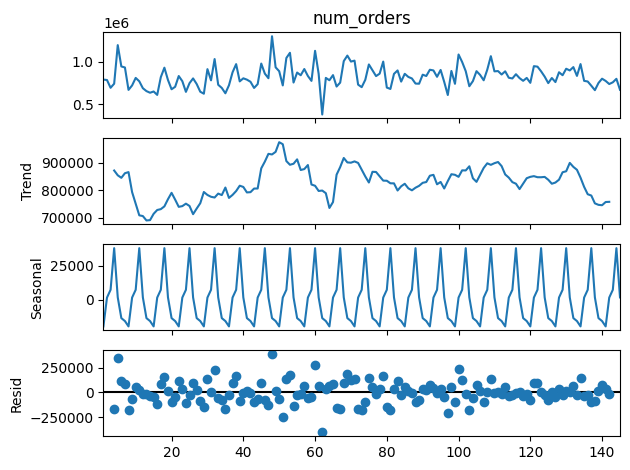

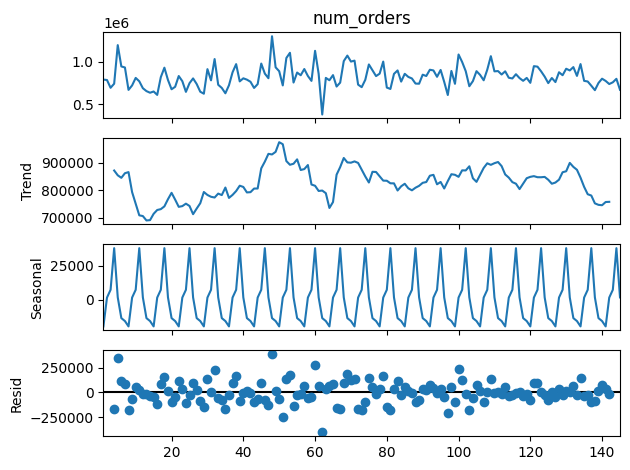

In [134]:
from statsmodels.tsa.seasonal import seasonal_decompose

decompose = seasonal_decompose(weekly_order,period=7)
decompose.plot()

Check for stationarity using adfuller 

In [135]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(weekly_order)
result[1]

np.float64(0.10538983404031188)

In [136]:
#outlier removal
residual = decompose.resid.dropna()
mean = residual.mean()
std = residual.std()
upper_limit = mean + 3 * std
lower_limit = mean - 3 * std
capped_residual = residual.clip(upper=upper_limit,lower=lower_limit)


In [137]:
valid_idx = decompose.resid.dropna().index
valid_idx

Index([  4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
       ...
       133, 134, 135, 136, 137, 138, 139, 140, 141, 142],
      dtype='int64', name='week', length=139)

In [138]:
clean_weekly_order = (decompose.trend.loc[valid_idx]+
                      decompose.seasonal.loc[valid_idx]+
                      capped_residual)
clean_weekly_order

week
4      7.435290e+05
5      1.191385e+06
6      9.472880e+05
7      9.348030e+05
8      6.705180e+05
           ...     
138    6.673430e+05
139    7.519350e+05
140    8.026890e+05
141    7.762400e+05
142    7.396610e+05
Length: 139, dtype: float64

In [139]:
#Differencing once give adfuller p value <0.05
clean_weekly_order = clean_weekly_order.diff().dropna()

In [140]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(clean_weekly_order)
result[1]

np.float64(2.856407005984802e-09)

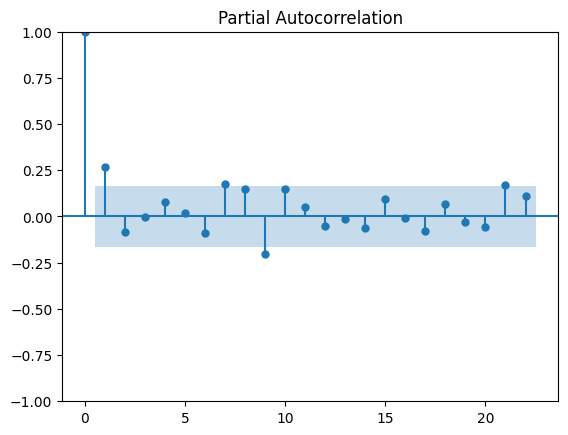

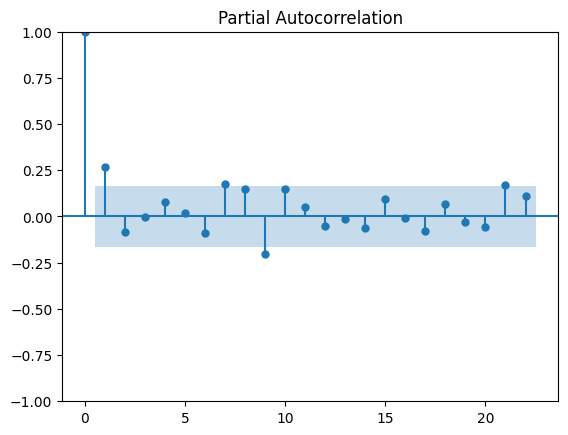

In [141]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(weekly_order)

Since there is no seasonality, go for ARIMA model p,q = 1

In [142]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(weekly_order,order=(1,1,1))
model_fit = model.fit()


c:\Users\sujin\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\sujin\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [143]:
forecast = model_fit.forecast(steps=7)
forecast

c:\Users\sujin\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\sujin\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


145    765824.963894
146    794858.354034
147    803835.425857
148    806611.120261
149    807469.359960
150    807734.726126
151    807816.776865
Name: predicted_mean, dtype: float64

In [144]:

forecast.values

array([765824.96389396, 794858.35403401, 803835.42585747, 806611.12026088,
       807469.35996003, 807734.72612581, 807816.77686526])

In [145]:
last_week = weekly_order.index[-1]
future_date = range(last_week+1,last_week+1+len(forecast))

forecast = pd.Series(forecast.values,index=future_date)
forecast

146    765824.963894
147    794858.354034
148    803835.425857
149    806611.120261
150    807469.359960
151    807734.726126
152    807816.776865
dtype: float64

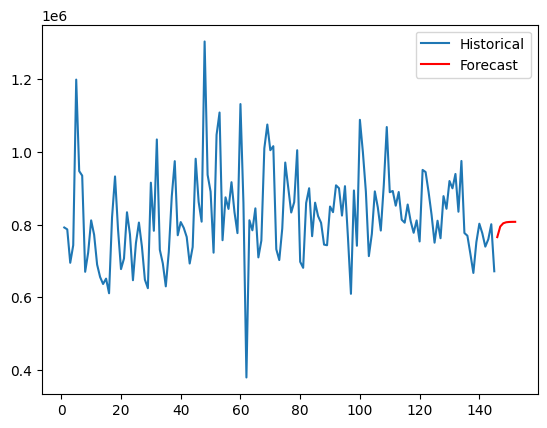

In [146]:
plt.plot(weekly_order, label='Historical')
plt.plot(forecast, label='Forecast', color='red')
plt.legend()
plt.show()

In [147]:
train = weekly_order[:-10]
test = weekly_order[-10:]
forecast = model_fit.forecast(steps=len(test))
forecast = pd.Series(forecast.values, index=test.index)


In [148]:
from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(test, forecast)
print("MAE:", mae)


MAE: 56501.135376223734


In [149]:
mape = np.mean(np.abs((test - forecast) / test)) * 100
print("MAPE:", mape, "%")


MAPE: 7.988734298300999 %


In [150]:
test.min(), test.max()

(np.int64(667343), np.int64(802689))

In [151]:
smape = np.mean(
    2 * np.abs(test - forecast) / (np.abs(test) + np.abs(forecast))
) * 100

print("sMAPE:", smape)


sMAPE: 7.467564235585436


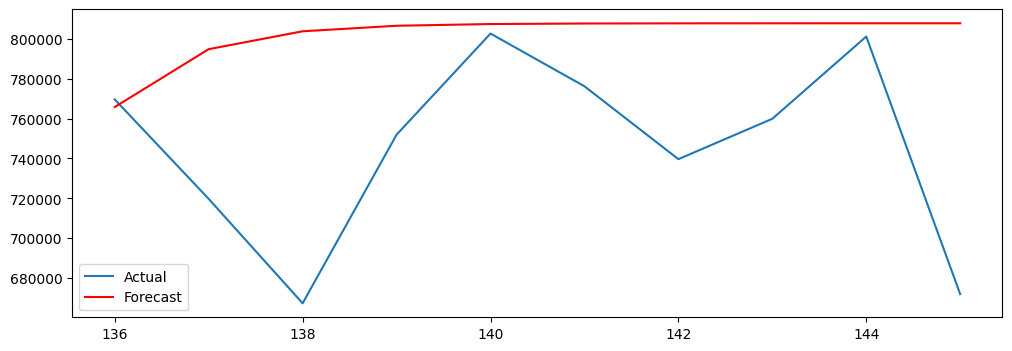

In [153]:
plt.figure(figsize=(12,4))
plt.plot(test, label="Actual")
plt.plot(forecast, label="Forecast", color="red")
plt.legend()
plt.show()
